In [1]:
from main import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


xFormers not available
xFormers not available


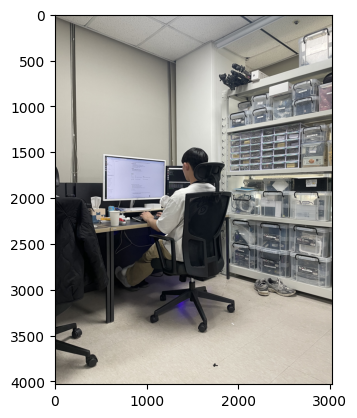

In [2]:
from matplotlib import pyplot as plt

image_path = "./sample.jpg"
raw_img = cv2.imread(image_path)
rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)  # 이미지 변환 (BGR -> RGB)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.imshow(rgb_img)

In [3]:

print("Depth Estimation running...")
de_model = load_depth_model(device)

print("YOLOv8 running...")
results = load_yolo_model_and_run(rgb_img, cfg.OD_MODEL_PATH, conf_threshold=0.6)

Depth Estimation running...
YOLOv8 running...

0: 640x480 1 person, 1 cup, 3 chairs, 1 tv, 14.1ms
Speed: 2.7ms preprocess, 14.1ms inference, 54.9ms postprocess per image at shape (1, 3, 640, 480)


In [4]:
# COCO_CLASS_INFO는 미리 위에서 정의한 딕셔너리라고 가정
def material_classification_and_weight(cropped_images, boxes, class_ids, depth_map, mtr_model, mtr_classes, result):
    depth_infos = []
    for i, (crop_img, box, cls_id) in enumerate(zip(cropped_images, boxes, class_ids)):
        # 3D 좌표 및 가로, 세로, 깊이 정보 얻기
        points, x, y, z = depth_to_pointcloud(depth_map, box)

        # 실제 측정한 가로, 세로, 깊이
        width = np.max(x) - np.min(x)
        height = np.max(y) - np.min(y)
        depth = np.mean(z)

        # 부피 계산
        volume = calc_volume(points)

        # 클래스 이름 가져오기
        class_name = result.names[cls_id]

        # 평균 크기 및 무게 가져오기
        if class_name in cfg.COCO_CLASS_INFO:
            avg_info = cfg.COCO_CLASS_INFO[class_name]

            avg_width = avg_info['width']
            avg_height = avg_info['height']
            avg_depth = avg_info['depth']
            avg_weight = avg_info['weight']

            # 부피 비율로 보정 (3축 모두)
            average_volume = avg_width * avg_height * avg_depth

            if average_volume > 0:
                volume_ratio = volume / average_volume
                weight = avg_weight * volume_ratio
            else:
                weight = avg_weight  # 혹시 평균 부피가 0이면 그냥 평균 무게 사용
        else:
            # 클래스 정보가 없으면 조정 없이 0
            weight = 0

        depth_infos.append({
            "id": i,
            "class": class_name,
            "volume": volume,
            "width": width,
            "height": height,
            "depth": depth,
            "weight": weight * 10,
        })

    return depth_infos


In [5]:
cropped_images, boxes, class_ids, class_names = extract_bounding_boxes_and_crops(results)

mtr_model, mtr_classes = init_model()
depth_infos = material_classification_and_weight(cropped_images, boxes, class_ids, de_model.infer_image(rgb_img), mtr_model, mtr_classes, results[0])

# BBox 옆에 라벨 추가
for i, (box, cls_id) in enumerate(zip(boxes, class_ids)):
    x1, y1, x2, y2 = box
    volume = depth_infos[i]['volume']
    weight = depth_infos[i]['weight']
    width = depth_infos[i]['width']
    height = depth_infos[i]['height']
    depth = depth_infos[i]['depth']
    
    label = f"{results[0].names[cls_id]}, Vol: {volume:.1f}cm^3, W: {weight:.1f}kg"
    dimension_info = f"W: {width:.1f}, H: {height:.1f}cm, D: {depth:.1f}cm"
    print(label, dimension_info)
    
    # BBox 그리기
    cv2.rectangle(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # 라벨 추가
    cv2.putText(rgb_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 2)
    cv2.putText(rgb_img, dimension_info, (x1, y2 + 15), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 2)

chair, Vol: 27339.0cm^3, W: 8.5kg W: 135.7, H: 228.3cm, D: 3.1cm
person, Vol: 23834.0cm^3, W: 65.4kg W: 163.2, H: 168.4cm, D: 2.6cm
tv, Vol: 2837.0cm^3, W: 3.4kg W: 58.8, H: 51.4cm, D: 2.0cm
cup, Vol: 331.0cm^3, W: 1.6kg W: 15.0, H: 21.1cm, D: 3.4cm
chair, Vol: 43922.0cm^3, W: 13.7kg W: 121.4, H: 379.7cm, D: 4.5cm
chair, Vol: 1685.0cm^3, W: 0.5kg W: 45.0, H: 40.3cm, D: 2.8cm


In [6]:
output_path = "2.png"

# RGB 이미지를 저장 (BGR로 변환하여 저장)
output_bgr = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)  # 다시 BGR로 변환
cv2.imwrite(output_path, output_bgr)
print("Image saved as output.png")

Image saved as output.png
